# Exploratory Data Analysis: preprocessing, data cleansing, statistical analysis and visualizations

### 1. import the necessary libraries for the analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 2. load data files and merge them into one DataFrame

Loading college player statistical data from 2009 to 2022. The data can be found in two different csv files, one contains stats from 2009 to 2021, while the other one contains the latest statistics (2022):

In [3]:
college1 = pd.read_csv('Data\CollegeBasketballPlayers2009-2021.csv',low_memory=False)
college2 = pd.read_csv('Data\CollegeBasketballPlayers2022.csv',low_memory=False)

The other data source contains draft picks at the nba draft for each year from 2009 to 2021:

In [4]:
draft = pd.read_excel('Data\DraftedPlayers2009-2021.xlsx')

First of all, I concatenate the college statistical dataframes:

In [5]:
college = pd.concat([college1,college2])
print(college1.size+college2.size == college.size)

True


Since the draft data set has merged cells in the table header I drop the first row:

In [6]:
draft.drop(0,axis=0,inplace=True)

Renaming the ROUND.1 column to PICK, and modifying the PLAYER to player_name, so it behaves as a key column with the college data set during the join method:

In [7]:
draft.rename(
    columns={
        "PLAYER": "player_name", 
        "TEAM": "drafted_by", 
        "YEAR" : "year", 
        "ROUND" : "draft_round", 
        "ROUND.1" : "draft_pick"},
        inplace=True)

Converting all column names to lowcase letters:

In [8]:
draft.columns = draft.columns.str.lower()

Merging the college set with the draft data to identify those players who have been drafted after playing in college:

In [9]:
df = pd.merge(college,draft,how='left',on=['player_name','year'])

### 3. clean the data set and prepare it for statistical analyzis and further analytical steps

Creating a new column to identify the drafted players:

In [10]:
df['drafted_flag'] = (~df.overall.isnull())*1

Since the draft data does not contain information about 2022, rows for 2022 should be removed from the 'df' data set and saved into a new dataframe:

In [11]:
df_2022 = df[df.year == 2022]
df = df[df.year < 2022]

Renaming unnamed column 64 for clearity:

In [12]:
df.rename(columns={'Unnamed: 64':'player_position'},inplace=True)

Dropping unknown, irrelevant (not statistical, such as 'num': jersey number column) or dupplicate columns:

In [13]:
# find NaN or null values
print(df.isnull().sum().sort_values(ascending=False))

overall         60459
draft_pick      60459
draft_round     60459
affiliation     60459
drafted_by      60459
                ...  
adjoe               0
pfr                 0
year                0
pid                 0
drafted_flag        0
Length: 72, dtype: int64


In [14]:
# unknown with nan values
df = df.drop('Unnamed: 65', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('pick', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('overall', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('affiliation', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('draft_round', axis=1)
# irrelevant, it can be used for more sophisticated prediction tasks
df = df.drop('draft_pick', axis=1)
# irrelevant, not statistical data (jersey number)
df = df.drop('num', axis=1)
# irrelevant, not statistical data (player id in the database)
df = df.drop('pid', axis=1)
# irrelevant, not statistical data (unique value for all rows)
df = df.drop('type', axis=1)

Handling missing values:

In [15]:
df.drafted_flag.fillna(value=0, inplace=True)
df.yr.fillna(value='None', inplace=True)
df.player_position.fillna(value='None', inplace=True)

Checking non integer columns and find the categorical values:

In [16]:
df_nonint = df.select_dtypes(exclude=['int64','float'])
df_nonint.columns

Index(['player_name', 'team', 'conf', 'yr', 'ht', 'player_position',
       'drafted_by', 'drafted_flag'],
      dtype='object')

In [17]:
df_nonint.nunique()

player_name        25719
team                 362
conf                  36
yr                     8
ht                    39
player_position        9
drafted_by            34
drafted_flag           2
dtype: int64

Checking distinct values for object type 'yr' column:

In [18]:
print(df.yr.value_counts())

Jr      16241
Fr      16233
So      14485
Sr      13801
None      294
0           5
57.1        1
42.9        1
Name: yr, dtype: int64


Handling mistyped or wrong values:

In [19]:
df.yr.replace('0', 'None', inplace=True)
df.yr.replace('57.1', 'None', inplace=True)
df.yr.replace('42.9', 'None', inplace=True)

One hot encoding categorical column: yr

In [20]:
df = pd.get_dummies(df, columns=['yr'])

Reordering columns to have drafted_flag as the last column of the dataframe:

In [21]:
col_list = df.columns.tolist()
col_list.pop(-6)  # 'drafted_flag'
col_list.append('drafted_flag')
df = df[col_list]

Examining non-numeric columns:

In [22]:
print(df.dtypes.value_counts())
print(df.select_dtypes('object').columns)

float64    47
int64       8
object      6
uint8       5
int32       1
dtype: int64
Index(['player_name', 'team', 'conf', 'ht', 'player_position', 'drafted_by'], dtype='object')


Leaving only numeric data and fill all remaining columns with zeros:

In [23]:
df = df.select_dtypes(exclude='object')
df.fillna(value=0, inplace=True)

Examining data for the drafted_flag column:

In [24]:
print(df.groupby(['year','drafted_flag'])['drafted_flag'].count())

year  drafted_flag
2009  0               4542
      1                 47
2010  0               4645
      1                 53
2011  0               4502
      1                 46
2012  0               4535
      1                 51
2013  0               4566
      1                 42
2014  0               4679
      1                 43
2015  0               4681
      1                 43
2016  0               4656
      1                 41
2017  0               4695
      1                 48
2018  0               4661
      1                 42
2019  0               4692
      1                 48
2020  0               4685
      1                 48
2021  0               4920
      1                 50
Name: drafted_flag, dtype: int64


### 4. create visualizations and analyze statistics

Calculating basic statistics:

In [25]:
df.describe()

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,ast,stl,blk,pts,yr_Fr,yr_Jr,yr_None,yr_So,yr_Sr,drafted_flag
count,61061.000000,61061.00000,61061.000000,61061.000000,61061.000000,61061.000000,61061.00000,61061.000000,61061.000000,61061.000000,...,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000,61061.000000
mean,22.797760,37.12839,91.666396,18.126341,44.500768,47.584212,5.54225,12.704242,10.808699,20.225856,...,1.072110,0.529117,0.280821,5.769986,0.265849,0.265980,0.004929,0.237222,0.226020,0.009859
std,10.166805,28.05805,30.963736,6.253742,18.431761,17.640613,9.30561,10.755123,9.362704,12.318765,...,1.169619,0.469654,0.414815,4.948427,0.441788,0.441857,0.070038,0.425383,0.418256,0.098803
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,9.30000,83.900000,14.500000,40.000000,43.800000,1.80000,8.400000,4.600000,14.700000,...,0.222200,0.157900,0.000000,1.571400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,35.60000,97.100000,18.100000,47.700000,50.850000,4.30000,11.900000,9.000000,19.100000,...,0.677400,0.424200,0.133300,4.482800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,62.00000,106.900000,21.800000,53.300000,56.110000,8.10000,16.100000,15.000000,24.400000,...,1.533300,0.793100,0.363600,9.062500,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,41.000000,98.00000,834.000000,50.000000,150.000000,150.000000,1576.60000,1385.000000,100.000000,100.000000,...,10.000000,4.000000,5.258100,30.090900,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Creating correlation matrix:

In [26]:
corr_matrix = df.corr()
corr_matrix = corr_matrix[abs(corr_matrix) < 1]
corr_matrix = corr_matrix.stack().reset_index()
corr_matrix.columns = ['Variable1','Variable2','Correlation']
print(corr_matrix)

         Variable1 Variable2  Correlation
0               GP   Min_per     0.766095
1               GP      Ortg     0.436458
2               GP       usg     0.194152
3               GP       eFG     0.410425
4               GP    TS_per     0.428273
...            ...       ...          ...
3655  drafted_flag     yr_Fr    -0.003767
3656  drafted_flag     yr_Jr    -0.014300
3657  drafted_flag   yr_None    -0.007023
3658  drafted_flag     yr_So    -0.001873
3659  drafted_flag     yr_Sr     0.022168

[3660 rows x 3 columns]


Calculating the empirical distribution of the target feature per year:

In [27]:
drafted_per_year = df[df.drafted_flag == 1].groupby('year').count()['drafted_flag']
count_per_year = df.groupby('year').count()['GP']
yearly_drafts = drafted_per_year/count_per_year
print(yearly_drafts)

year
2009    0.010242
2010    0.011281
2011    0.010114
2012    0.011121
2013    0.009115
2014    0.009106
2015    0.009102
2016    0.008729
2017    0.010120
2018    0.008930
2019    0.010127
2020    0.010142
2021    0.010060
dtype: float64


Plotting the heatmap of the correlations:

<Axes: >

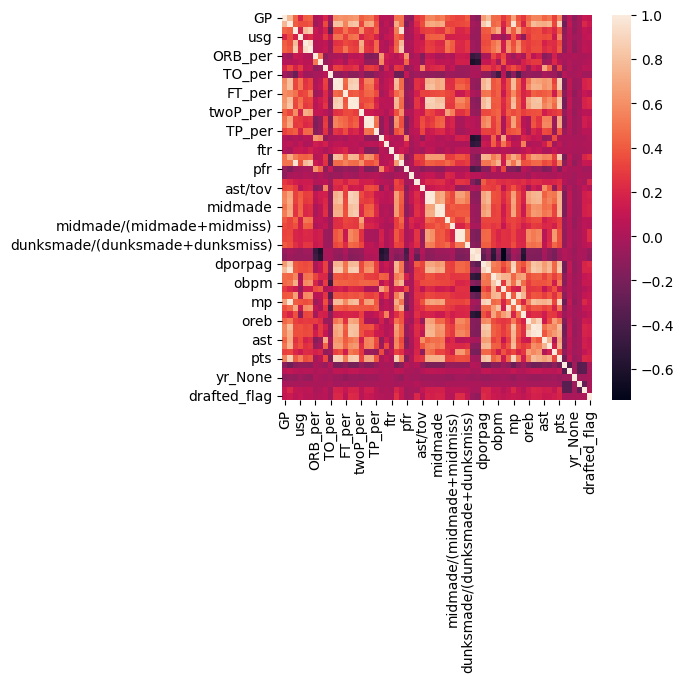

In [28]:
# plot settings
plt.rcParams['figure.figsize']=(5,5)

# heatmap of the correlations
sns.heatmap(df.corr(),annot=False)

Plotting the histogram of the target feature:

<Axes: xlabel='drafted_flag', ylabel='Count'>

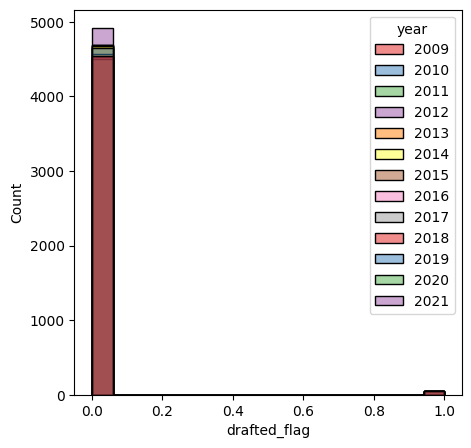

In [29]:
sns.histplot(data=df, x="drafted_flag", hue="year",palette="Set1")

Checking the ratio of the target feature labels:

In [30]:
df.drafted_flag.value_counts()

0    60459
1      602
Name: drafted_flag, dtype: int64

Checking the correlations with the highest absolute value between the target feature and the predictors:

In [31]:
drafted_corr_matrix = corr_matrix[corr_matrix.Variable1 == 'drafted_flag'].sort_values(by='Correlation',ascending=False)
print(drafted_corr_matrix.sort_values(by='Correlation',ascending=False))

         Variable1                        Variable2  Correlation
3622  drafted_flag                           porpag     0.250765
3634  drafted_flag                        dunksmade     0.227100
3635  drafted_flag              dunksmiss+dunksmade     0.223806
3639  drafted_flag                          dporpag     0.221672
3613  drafted_flag                            twoPM     0.219013
3610  drafted_flag                              FTM     0.210367
3611  drafted_flag                              FTA     0.204868
3614  drafted_flag                            twoPA     0.204032
3626  drafted_flag                         Rec Rank     0.200200
3654  drafted_flag                              pts     0.191454
3630  drafted_flag                          midmade     0.188799
3640  drafted_flag                            stops     0.186134
3631  drafted_flag                  midmade+midmiss     0.185105
3628  drafted_flag                          rimmade     0.182256
3649  drafted_flag       

### 5. Random model creation

I use the empirical distribution of the drafted flag feature to create a random model predicting the drafted players (Bernoulli distribution):

In [32]:
from scipy.stats import bernoulli

# probability of drafted flag = 1
prob_drafted = np.average(yearly_drafts)

# random model with the given Bernoulli distribution with the length of
rand_model = pd.DataFrame(data=[bernoulli(prob_drafted).rvs(len(df))])
rand_model = rand_model.transpose()
rand_model.columns = ['pred_drafted_flag']

print(rand_model.value_counts())

pred_drafted_flag
0                    60453
1                      608
dtype: int64


### 6. Random model evaluation

Evaluating the random model:

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

cm = confusion_matrix(y_pred=rand_model.pred_drafted_flag, y_true=df.drafted_flag)
cp = classification_report(y_pred=rand_model.pred_drafted_flag, y_true=df.drafted_flag)
ba = balanced_accuracy_score(y_pred=rand_model.pred_drafted_flag, y_true=df.drafted_flag)

print(cm, cp, "Balanced accuracy: {}".format(ba), sep='\n')

[[59860   599]
 [  593     9]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     60459
           1       0.01      0.01      0.01       602

    accuracy                           0.98     61061
   macro avg       0.50      0.50      0.50     61061
weighted avg       0.98      0.98      0.98     61061

Balanced accuracy: 0.502521312732788


### Advanced statistics

Let's do some statistical calculations that are invented by scientists in order to measure the efficiency of basketball players based on their statistics througout their college career.

EFF:

(PTS + REB + AST + STL + BLK − Missed FG − Missed FT - TO) / GP

credit: https://en.wikipedia.org/wiki/Efficiency_(basketball)#:~:text=Individual%20player%20efficiency%20is%20expressed,reporter%20and%20statistician%20Martin%20Manley.

PER, also called the NBA efficiency:

uPER = (1 / MP) *
     [ 3P
     + (2/3) * AST
     + (2 - factor * (team_AST / team_FG)) * FG
     + (FT *0.5 * (1 + (1 - (team_AST / team_FG)) + (2/3) * (team_AST / team_FG)))
     - VOP * TOV
     - VOP * DRB% * (FGA - FG)
     - VOP * 0.44 * (0.44 + (0.56 * DRB%)) * (FTA - FT)
     + VOP * (1 - DRB%) * (TRB - ORB)
     + VOP * DRB% * ORB
     + VOP * STL
     + VOP * DRB% * BLK
     - PF * ((lg_FT / lg_PF) - 0.44 * (lg_FTA / lg_PF) * VOP) ]

factor = (2 / 3) - (0.5 * (lg_AST / lg_FG)) / (2 * (lg_FG / lg_FT))

VOP    = lg_PTS / (lg_FGA - lg_ORB + lg_TOV + 0.44 * lg_FTA)

DRB%   = (lg_TRB - lg_ORB) / lg_TRB

pace adjustment = lg_Pace / team_Pace

aPER = (pace adjustment) * uPER

PER = aPER * (15 / lg_aPER)


credit: https://www.basketball-reference.com/about/per.html

Visualizing the main basic statistics that are necessary for the EFF and PER calculations:

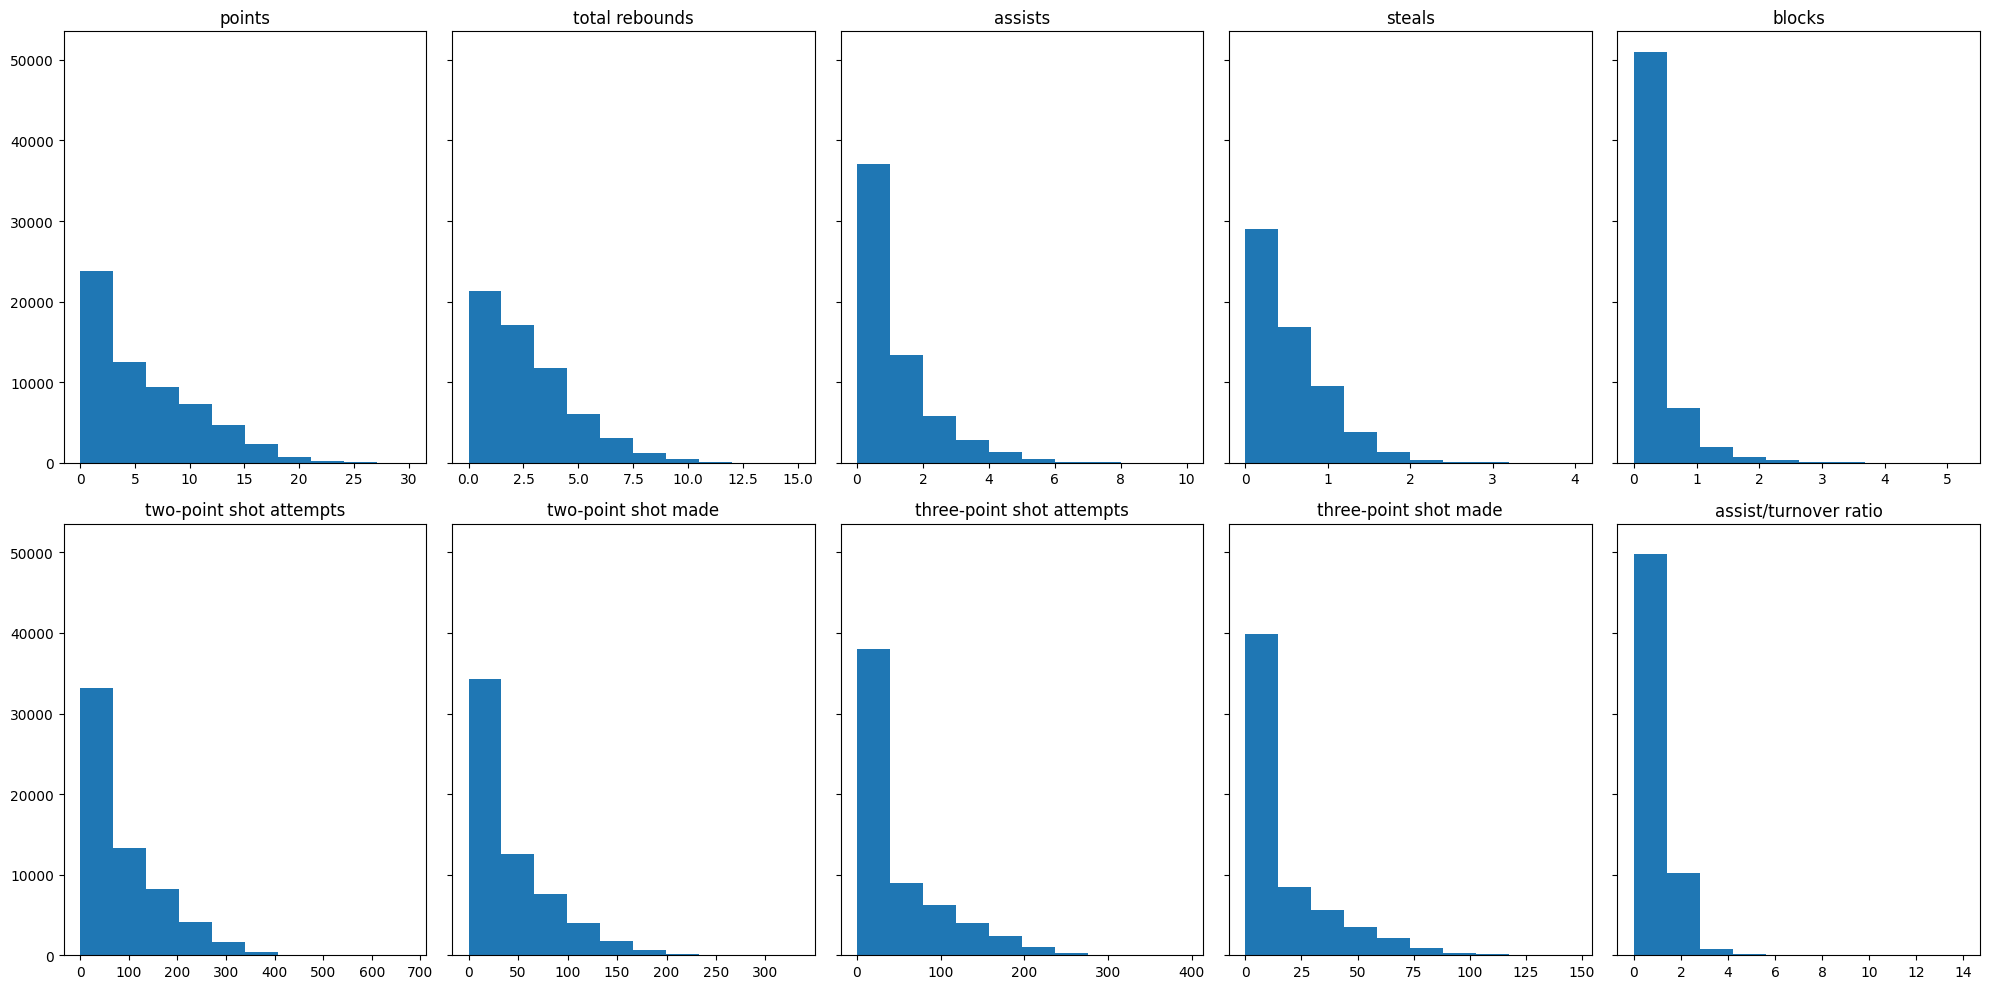

In [34]:
# plot settings
plt.rcParams['figure.figsize']=(20,10)
fig, axs = plt.subplots(2, 5, sharey=True, tight_layout=True)

axs[0,0].hist(df['pts'])
axs[0,0].title.set_text('points')

axs[0,1].hist(df['treb'])
axs[0,1].title.set_text('total rebounds')

axs[0,2].hist(df['ast'])
axs[0,2].title.set_text('assists')

axs[0,3].hist(df['stl'])
axs[0,3].title.set_text('steals')

axs[0,4].hist(df['blk'])
axs[0,4].title.set_text('blocks')
#xxxxxxx
axs[1,0].hist(df['twoPA'])
axs[1,0].title.set_text('two-point shot attempts')

axs[1,1].hist(df['twoPM'])
axs[1,1].title.set_text('two-point shot made')

axs[1,2].hist(df['TPA'])
axs[1,2].title.set_text('three-point shot attempts')

axs[1,3].hist(df['TPM'])
axs[1,3].title.set_text('three-point shot made')

axs[1,4].hist(df['ast/tov'])
axs[1,4].title.set_text('assist/turnover ratio')

plt.show()

Calculating efficiency (EFF):

In [35]:
eff = (df.pts + df.treb + df.ast + df.stl + df.blk - (df.twoPA + df.TPA - df.twoPM - df.TPM) - (df['ast/tov']*(1/df.ast)))/df.GP
eff.fillna(0,inplace=True)
df['eff'] = eff
# eff.sort_values(ascending=False,inplace=True)

In [40]:
df.eff.sort_values(ascending=False)

32946    28.500000
37732    26.666667
13877    23.750000
18141    22.800000
28446    22.500000
           ...    
49374   -11.149026
41061   -11.186320
53012   -11.686695
53982   -11.750690
50570   -12.017881
Name: eff, Length: 61061, dtype: float64

In [42]:
ind = np.argsort(eff)[::-1][:50]
eff[ind]
ind

61060    32946
61059    37732
61058    13877
61057    18141
61056    28446
61055    11550
61054    45968
61053    47811
61052    51273
61051    59527
61050    56886
61049    45832
61048    59418
61047    38038
61046     5699
61045    42803
61044    14582
61043    38904
61042    20439
61041    59426
61040    54823
61039    19303
61038    57431
61037    50275
61036    58594
61035    58495
61034    53316
61033    60236
61032    57036
61031    25363
61030    21928
61029    58073
61028    13011
61027    30897
61026    41133
61025    12301
61024    60357
61023    55955
61022     8851
61021    37586
61020    59341
61019    56858
61018    43532
61017    10047
61016    16201
61015    56457
61014    44492
61013    56522
61012    29328
61011    48546
dtype: int64

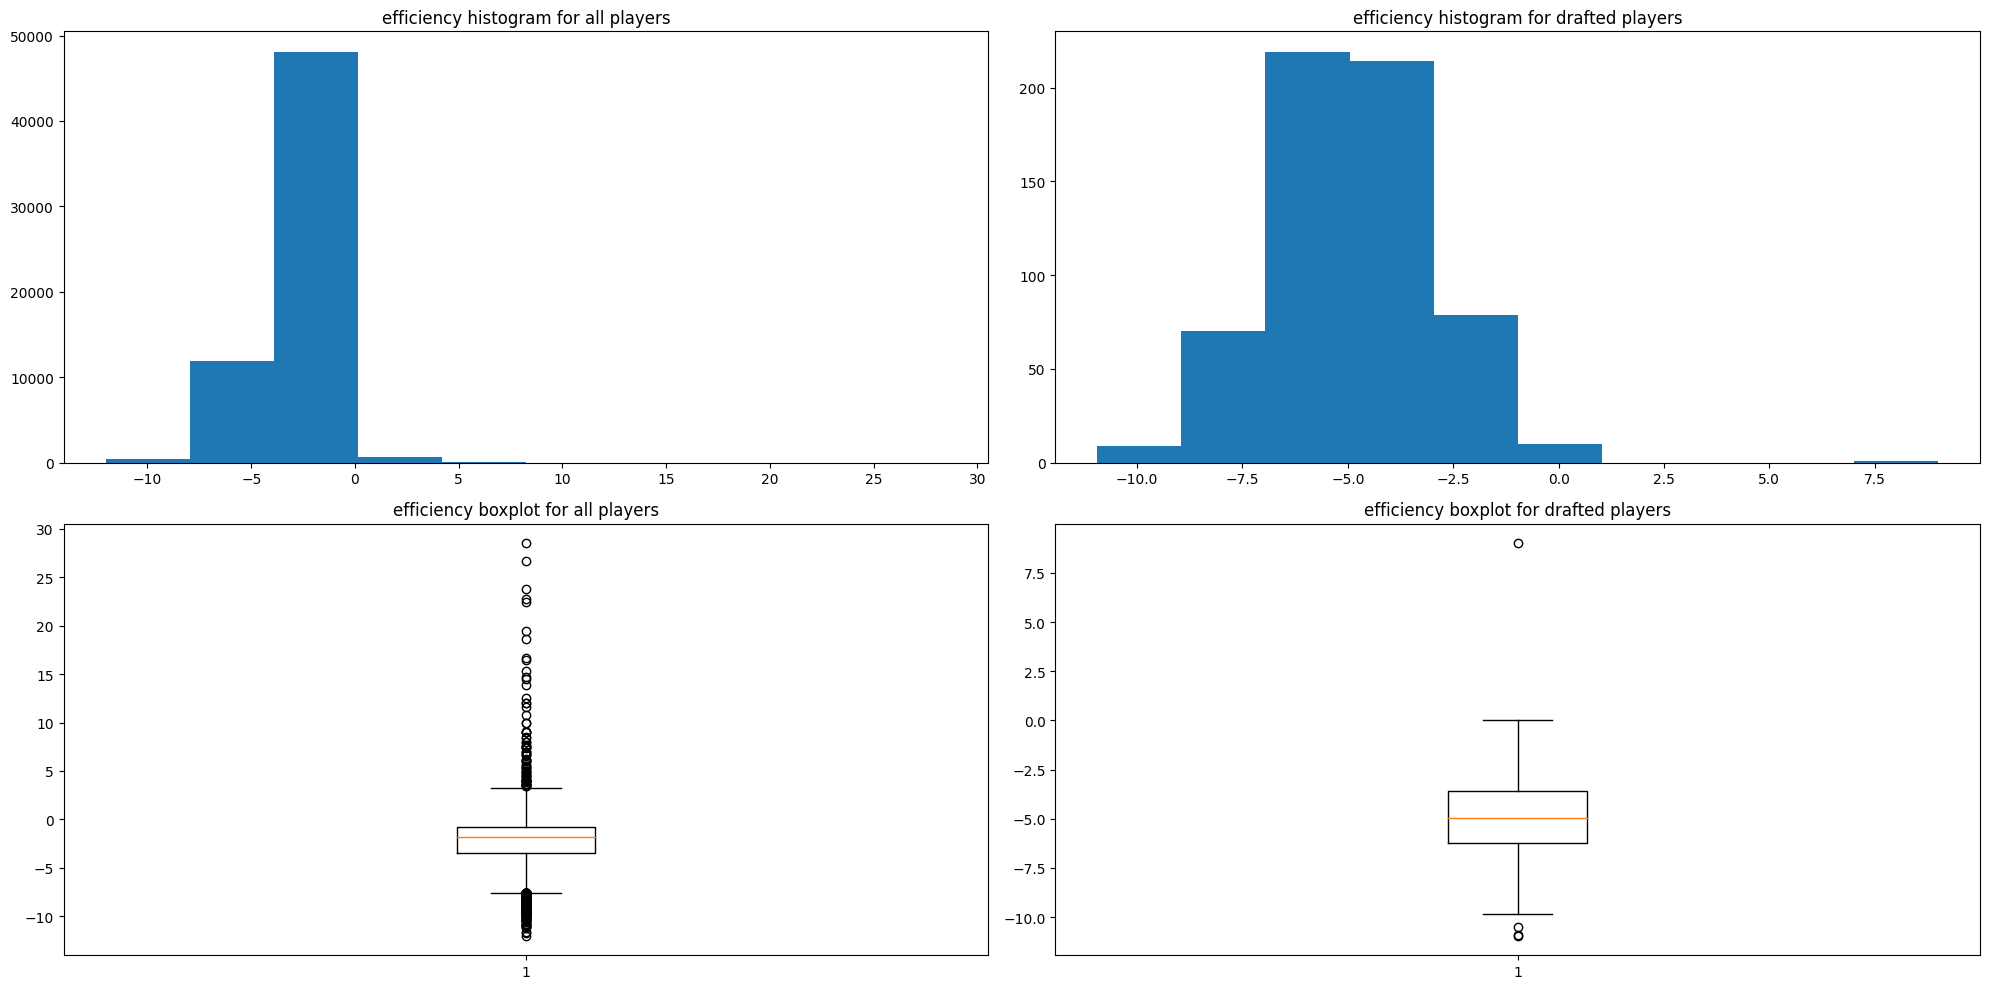

In [35]:
df_drafted = df[df.drafted_flag == 1]
# boxplot the efficiency values
plt.rcParams['figure.figsize']=(20,10)
fig, axs = plt.subplots(2, 2, tight_layout=True)

axs[0,0].hist(df['eff'])
axs[0,0].title.set_text('efficiency histogram for all players')

axs[0,1].hist(df_drafted['eff'])
axs[0,1].title.set_text('efficiency histogram for drafted players')

axs[1,0].boxplot(df['eff'])
axs[1,0].title.set_text('efficiency boxplot for all players')

axs[1,1].boxplot(df_drafted['eff'])
axs[1,1].title.set_text('efficiency boxplot for drafted players')

PER unfortunately cannot be calculated since the data set does not contain the necessary information for the statistics.